# Install Libraries

In [ ]:
!pip install pytube youtube-transcript-api opencv-python psycopg2


# Import Dependencies

In [28]:
import cv2
from google.colab import drive
from google.colab import files
# google patch for cv2.imshow
from google.colab.patches import cv2_imshow
from google.colab import userdata
import numpy as np
import os
import pandas as pd
import psycopg2
from psycopg2 import sql
from pycocotools.coco import COCO
from pytube import YouTube
import re
import tensorflow as tf
import tensorflow_hub as hub
from youtube_transcript_api import YouTubeTranscriptApi

# Video Search




## Step 1:  Video library (10 points)

Write a python API  that will download the video and its closed captions from youtube. Make sure to document how one can use your API. Use this to download the following videos from youtube along with thei captions:

https://www.youtube.com/watch?v=wbWRWeVe1XE

https://www.youtube.com/watch?v=FlJoBhLnqko

https://www.youtube.com/watch?v=Y-bVwPRy_no

# YouTube API

To download the video and captions of a specified list of videos, instantiate the YouTubeDownloader class with a list of video_ids (the string that comes after 'https://www.youtube.com/watch?v=' in the YouTube URL). Call the download_all attribute with the output path as an argument to download both the video and captions, or call the download_video and download_captions attributes with the video_id list and output path as arguments to download videos or captions separately

In [3]:
class YouTubeDownloader:
    """
    A class for downloading YouTube videos and their captions.

    Parameters:
    - video_ids (list): A list of YouTube video IDs to be downloaded.

    Methods:
    - download_video(video_id, output_path="."): Downloads a YouTube video by its ID.
    - download_captions(video_id, output_path="."): Downloads captions for a YouTube video by its ID.
    - download_all(output_path="."): Downloads videos and captions for all specified video IDs.

    Note:
    - The download paths for videos and captions are set within the 'videos' and 'captions' subdirectories.
    """

    def __init__(self, video_ids):
        self.video_ids = video_ids

    def download_video(self, video_id, output_path="."):
        try:
            yt = YouTube(f"https://www.youtube.com/watch?v={video_id}")
            video = yt.streams.filter(file_extension='mp4', resolution='360p').first()
            video_output = os.path.join(output_path, "videos")
            video.download(video_output)
            print(f"Video downloaded successfully: {yt.title}")
        except Exception as e:
            print(f"Error downloading video: {e}")

    def download_captions(self, video_id, output_path="."):
        try:
            transcript = YouTubeTranscriptApi.get_transcript(video_id)
            # clean up captions filename
            video_title = YouTube(f'https://www.youtube.com/watch?v={video_id}').title
            cleaned_filename = video_title.replace("'", "")
            cleaned_filename = re.sub(r'\s+', ' ', cleaned_filename)
            captions_filename = f"{cleaned_filename}_captions.txt"
            captions_path = os.path.join(output_path, "captions", captions_filename)

            with open(captions_path, "w", encoding="utf-8") as file:
                file.write(f"Video Title: {YouTube(f'https://www.youtube.com/watch?v={video_id}').title}\n")
                file.write(f"Video URL: https://www.youtube.com/watch?v={video_id}\n\n")
                for entry in transcript:
                    file.write(f"{entry['start']} - {entry['start'] + entry['duration']}\n")
                    file.write(f"{entry['text']}\n\n")
            print(f"Captions downloaded successfully: {YouTube(f'https://www.youtube.com/watch?v={video_id}').title}")
        except Exception as e:
            print(f"Error downloading captions: {e}")

    def download_all(self, output_path="."):
        for video_id in self.video_ids:
            self.download_video(video_id, output_path)
            self.download_captions(video_id, output_path)


In [5]:
# save files to Google Drive
drive.mount('./YouTubeDownloads')

video_ids = ["wbWRWeVe1XE", "FlJoBhLnqko", "Y-bVwPRy_no"]

# set separate output paths for videos and captions
output_path = "/content/drive/MyDrive/ColabNotebooks/YouTubeDownloads"
video_output_path = os.path.join(output_path, "videos")
caption_output_path = os.path.join(output_path, "captions")

# create the directories if they do not exist
os.makedirs(output_path, exist_ok=True)
os.makedirs(video_output_path, exist_ok=True)
os.makedirs(caption_output_path, exist_ok=True)

# download videos and captions to specified output paths
downloader = YouTubeDownloader(video_ids)
downloader.download_all(output_path)

Mounted at ./YouTubeDownloads
Video downloaded successfully: What Does 'High-Quality' Preschool Look Like? | NPR Ed
Captions downloaded successfully: What Does 'High-Quality' Preschool Look Like? | NPR Ed
Video downloaded successfully: How Green Roofs Can Help Cities | NPR
Captions downloaded successfully: How Green Roofs Can Help Cities | NPR
Video downloaded successfully: Why It’s Usually Hotter In A City | Let's Talk | NPR
Captions downloaded successfully: Why It’s Usually Hotter In A City | Let's Talk | NPR


In [6]:
# check directories to see if downloads were successful
print("Parent Directory:")
!ls $output_path
print("\nVideo Directory:")
!ls $video_output_path
print("\nCaptions Directory:")
!ls $caption_output_path

Parent Directory:
captions  videos

Video Directory:
'How Green Roofs Can Help Cities  NPR.mp4'
'What Does High-Quality Preschool Look Like  NPR Ed.mp4'
'Why It’s Usually Hotter In A City  Lets Talk  NPR.mp4'

Captions Directory:
'How Green Roofs Can Help Cities | NPR_captions.txt'
'What Does High-Quality Preschool Look Like? | NPR Ed_captions.txt'
'Why It’s Usually Hotter In A City | Lets Talk | NPR_captions.txt'


## Step 2: Video indexing pipeline (90 points)

In this step you will build and train your models to extract embeddings for the frames of your videos and store the extracted information in a database such as postgres for indexing the videos.

### 2.1 Preprocess the video (15 points)

You can use opencv, ffmpeg, gstreameer, https://pytorchvideo.org/ or any other library to implement the preprocessing steps as shown below:
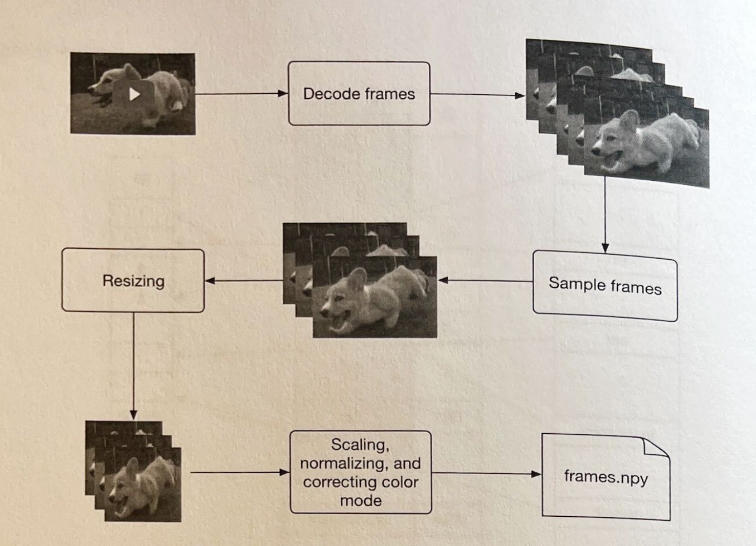



In [7]:
def preprocess_video_from_file(video_path, sample_rate, target_size, timestamps):
    """
    Preprocesses frames from a video file.

    Parameters:
    - video_path (str): Path to the video file.
    - sample_rate (int): Frame sampling rate, indicating the frequency of frame sampling (e.g., sample every N frames).
    - target_size (tuple): Target size for resizing frames, specified as (height, width).
    - timestamps (list): A list to store timestamps corresponding to each sampled frame.

    Returns:
    - numpy.ndarray: Array of preprocessed frames with shape (num_frames, height, width, channels).
      Each frame is resized, converted to RGB, and appended with its corresponding timestamp.

    Note:
    - The frames are resized to the specified target size.
    - Timestamps are saved in a separate array for each sampled frame.
    - Frames are not normalized because I found better performance without normalization, although I did attempt to normalize with mean/std then convert back to 0 <= uint8 >=255
    """

    # Create a VideoCapture object
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return None

    # Lists to store preprocessed frames
    frames = []

    # Iterate through the frames
    while True:
        # Read a frame from the video
        ret, frame = cap.read()

        # Check if the video has ended
        if not ret:
            break

        # Sample frames
        if cap.get(1) % sample_rate == 0:
            # Resize the frame
            frame = cv2.resize(frame, target_size)

            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # save timestamps to separate array
            timestamps.append(cap.get(cv2.CAP_PROP_POS_MSEC))

            # Append the preprocessed frame to the list
            frames.append(frame)

    # Release the VideoCapture object
    cap.release()

    # Returnlist of frames converted to a NumPy array
    return np.array(frames)

### 2.2 Detecting objects (25 points)

Use any of the pretrained object-detectors to detect objects belonging to MS COCO classes.
For each video, for each frame where a detection is found, compile and report the results in the following tabular structure :

[vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox info]

Feel free to finetune your detectors if required. If you notice that your model performs better on a different video from this [channel](https://www.youtube.com/@NPR), document this and you can use this video for the rest of this assignment.

### 2.3 Embedding model (30 points)

Develop a convolutional autoencoder such as [the one described here](https://blog.keras.io/building-autoencoders-in-keras.html) whose input will be all the objects detected in each frame (not the entire frame!), if any.
Note : You can downsample the frame rate of your original video to avoid long training/processing times. For a given input image, the autoencoder should output it's small vector embedding.

Train your autoencoder on the COCO dataset for classes which get detected in the given list of videos.

#### Extra credit (10 points)
Extra credit: if you want to maximize the possibility of developing something **new** think about how a video can be better segmented into representative frames. For example, [in this ~3min video accessed Nov 2023](https://youtu.be/FN8a8mZNik8?si=wXdbOGuLGkGsWsf) you have multiple scenes each one lasting 30sec or so. Can you find a way to segment each video and store the frame embeddings of each segment? This way there are multiple embeddings per video and you need to keep them that way for the subsequesnt steps of this project.

### Indexing the embeddings (20 points)

Use `docker compose` to bring up two docker containers, your application container with the dev environment (you must have done this in Step 1) and a second container with postgres.

`docker pull postgres:latest`

Process all the detected object sub-images for each frame of each video to compile your final results in the following tabular structure:
[vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox info, vector<embedding of this object>, optional<sceneId from extra credit>]

Index the video images embedding vectors in the database. To do that in postgres (with the pgvector extension) you can use [this guide](https://dev.to/sfoteini/image-vector-similarity-search-with-azure-computer-vision-and-postgresql-12f7).

Demonstrate that you can search the database using image queries and post the screenshots of your search results that must include the first 10 similar images across the input videos.


# Solution Problem 2.2

Load pretrained model from [kaggle](https://www.kaggle.com/models/tensorflow/faster-rcnn-inception-resnet-v2/frameworks/TensorFlow2/variations/640x640/versions/1)

In [ ]:
# Load the COCO pre-trained model from TensorFlow Hub
model_url = "https://www.kaggle.com/models/tensorflow/faster-rcnn-inception-resnet-v2/frameworks/TensorFlow2/variations/640x640/versions/1"
detector = hub.load(model_url)

Save the paths to all videos in youtube video directory, then sort the list to maintain consistent index ordering for use as Postgres video ID

In [8]:
# save all mp4 paths to video_paths list
video_paths = []
for root, dirs, files in os.walk(video_output_path):
  for file in files:
    full_path = os.path.join(root, file)
    video_paths.append(full_path)

video_paths.sort() # keep in sorted order for consistent IDs in PG instance

for video_path in video_paths:
  print(video_path)

/content/drive/MyDrive/ColabNotebooks/YouTubeDownloads/videos/How Green Roofs Can Help Cities  NPR.mp4
/content/drive/MyDrive/ColabNotebooks/YouTubeDownloads/videos/What Does High-Quality Preschool Look Like  NPR Ed.mp4
/content/drive/MyDrive/ColabNotebooks/YouTubeDownloads/videos/Why It’s Usually Hotter In A City  Lets Talk  NPR.mp4


# Connect to Supabase PG Instance and Create detectedObjects Table

In [ ]:
# establish connections using colab secrets
conn = psycopg2.connect(
    host=userdata.get("host"),
    port=userdata.get("port"),
    database=userdata.get("database"),
    user=userdata.get("user"),
    password=userdata.get("password")
    )

# create cursor
cursor = conn.cursor()

# Define the SQL query to create the table
create_table_query = sql.SQL("""
    CREATE TABLE IF NOT EXISTS detectedObjects (
        vidId INT,
        frameNum INT,
        timestamp FLOAT,
        detectedObjId INT,
        detectedObjClass VARCHAR(255),
        confidence FLOAT,
        bbox_info FLOAT[]
    )
""")

# Execute the SQL query
try:
  cursor.execute(create_table_query)
  print("Table created successfully.")
except Exception as e:
    print(f"Error executing the query: {e}")

# Commit the changes
conn.commit()

Table created successfully.


# Detected Class Dictionary
Created manually for convenience after testing my pretrained model and creating a set of classes

In [9]:
detected_classes = {
    1: 'person',
    2: 'bicycle',
    3: 'car',
    5: 'airplane',
    6: 'bus',
    7: 'train',
    8: 'truck',
    9: 'boat',
    10: 'traffic light',
    15: 'bench',
    16: 'bird',
    18: 'cat',
    27: 'backpack',
    28: 'umbrella',
    31: 'handbag',
    35: 'skis',
    41: 'skateboard',
    44: 'bottle',
    47: 'cup',
    51: 'fork',
    52: 'knife',
    62: 'chair',
    64: 'potted plant',
    67: 'dining table',
    76: 'keyboard',
    77: 'cell phone',
    85: 'clock',
    88: 'teddy bear'
}

# Use Pretrained Model to Detect Objects in NPR videos

I manually tested my hyperparameters mainly with the video, 'How Green Roofs Can Help Cities', due to its relative shortness and lower output. The most affective hyperparameter was by the the threshold, which I set to 0.95 in order to achieve a true positive rate of ~85-90% depending on the video. I found that maintaining the video's original aspect ratio achieved better results than squaring the frames according to the pretrained model's specifications, and that normalizing by mean and std before reconverting the values back to 0 <= uint8 <= 255 had a negligible if not negative effect on the overall results. I used the function, display_frame_with_bbox, defined below, to evaluate the results with all three videos. There are some results which suggest that the opencv frame capture or timestamp feature does not work consistently, e.g. I sometimes found a bounding box that appears to be occur 10 frames too early, as in the case of the man talking directly to the camera in 'How Green Roofs Can Help Cities', and found that this issue has been cited in OpenCV stackoverflow threads and github issues, but overall the results were fairly consistent.

In [ ]:
# Set the threshold
threshold = 0.95
# Parameters for frame sampling and preprocessing, standard ImageNet values for natural images: https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
sample_rate = 10  # Sample every 10 frames
target_size = (640, 360)  # Target width for resizing taken from pretrained model parameters, height maintains aspect ratio: https://www.kaggle.com/models/tensorflow/faster-rcnn-inception-resnet-v2/frameworks/TensorFlow2/variations/640x640/versions/1

# iterate over the paths in the video list, preprocess each video and detect objects, then upload detected object info to DB
for video_index, video in enumerate(video_paths):
  timestamps = []
  frames_array = preprocess_video_from_file(video_paths[video_index], sample_rate, target_size, timestamps)

  # iterate over preprocessed frames array from video
  for i, frame in enumerate(frames_array):
    # expand dimensions for model and input frame into model
    image_tensor = tf.expand_dims(frame, axis=0)
    detector_output = detector(image_tensor)

    # Convert confidence scores tensor to a NumPy array
    scores_tensor = detector_output["detection_scores"][0]
    scores_array = scores_tensor.numpy()

    # Find indices where the scores are greater than the threshold
    indices_above_threshold = np.where(scores_array > threshold)[0]

    # Save scores and corresponding classes to Supabase PG instance
    for index in indices_above_threshold:
      # Values to insert into DB
      values_to_insert = (video_index,      # video id
                        (i * sample_rate),  # correct frame number by sample_rate
                        timestamps[i],      # timestamp
                        float(detector_output["detection_classes"][0][index].numpy()), # object ID, convert to float for psycopg compatibility
                        detected_classes.get(detector_output["detection_classes"][0][index].numpy()), # object class taken from dict defined above
                        float(scores_array[index]),  # confidence, also converted to float for psycoph compatibility
                        detector_output["detection_boxes"][0][index].numpy().tolist()  # bbox info, converted to list of floats for psycopg compatibility
                        )

      # Define the SQL query to insert values into the table
      insert_query = sql.SQL("""
        INSERT INTO detectedObjects (vidId, frameNum, timestamp, detectedObjId, detectedObjClass, confidence, bbox_info)
        VALUES (%s, %s, %s, %s, %s, %s, %s);
      """)

      # Execute the insert query
      cursor.execute(insert_query, values_to_insert)

      # Commit the changes
      conn.commit()

# Testing Detected Object Data

As can be seen from the screenshots, the model largely works effectively. This slice of results was chosen to show the false positive in this set, which clearly shows the correct bounding box for 10 frames later

In [10]:
def display_frame_with_bbox(video_path, frame_number, object_id, confidence, bbox):
    """
    Display a video frame with a bounding box and object information.

    Parameters:
    - video_path (str): The path to the video file.
    - frame_number (int): The frame number to display.
    - object_id (int): The detected object's ID.
    - confidence (float): The confidence score of the detected object.
    - bbox (tuple): Bounding box coordinates in the format (y_min, x_min, y_max, x_max).

    Returns:
    None

    This function opens a video file specified by 'video_path', reads the frame at the given
    'frame_number', draws a bounding box around the detected object specified by 'bbox', and
    displays the frame with additional information about the object (object ID and confidence).
    The bounding box and text information are drawn in green and red, respectively.

    Note:
    - Make sure to import the 'cv2' and 'cv2_imshow' modules before using this function.
    - This function is specifically designed for use in Google Colab, where 'cv2.imshow()' may not work,
      so 'cv2_imshow()' from 'google.colab.patches' is used for displaying the frame.
    """
    # Create a VideoCapture object
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Set the frame number for the preprocessed video
    frame_to_display = frame_number

    # Set the VideoCapture object to the desired frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_to_display)

    # Read the frame
    ret, frame = cap.read()

    # Check if the frame is read successfully
    if not ret:
        print("Error: Could not read frame.")
        return

    # Get the original width and height of the frame
    original_height, original_width = frame.shape[:2]

    # Draw bounding box on the original-sized frame
    y_min, x_min, y_max, x_max = bbox
    x_min_scaled, y_min_scaled, x_max_scaled, y_max_scaled = (
        int(x_min * original_width),
        int(y_min * original_height),
        int(x_max * original_width),
        int(y_max * original_height),
    )
    cv2.rectangle(frame, (x_min_scaled, y_min_scaled), (x_max_scaled, y_max_scaled), (0, 255, 0), 2)  # Green rectangle

    # Display bounding box information on the frame
    text = f"Object: {object_id}, Confidence: {confidence}"
    cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)  # Red text

    # Display the frame, colab does not get along with cv2.imshow(), so imported patch from google.colab.patches
    cv2_imshow(frame)

    # Release the VideoCapture object
    cap.release()

Frame Number:  160
Timestamp:  7048.7


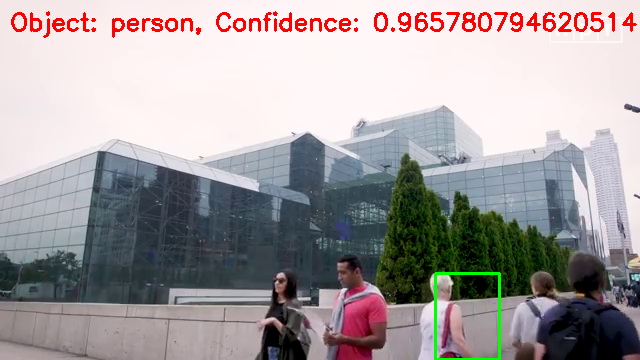


Frame Number:  170
Timestamp:  7465.78888888889


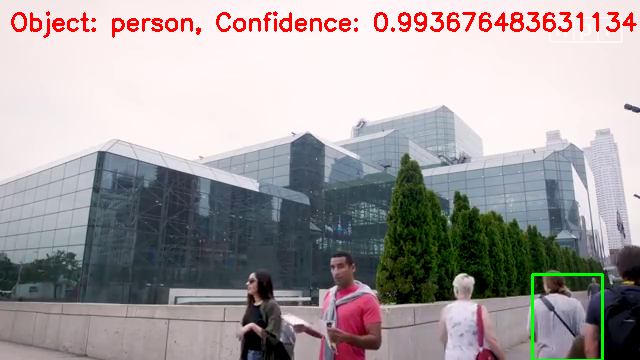


Frame Number:  170
Timestamp:  7465.78888888889


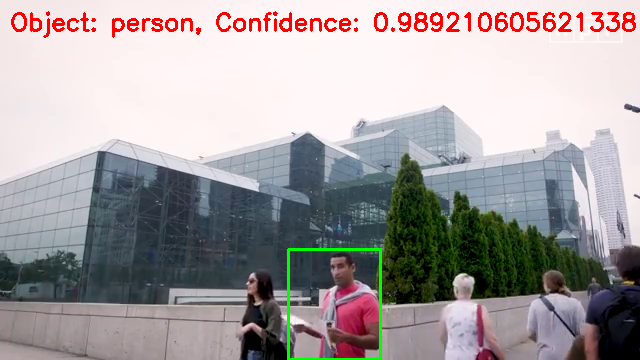


Frame Number:  170
Timestamp:  7465.78888888889


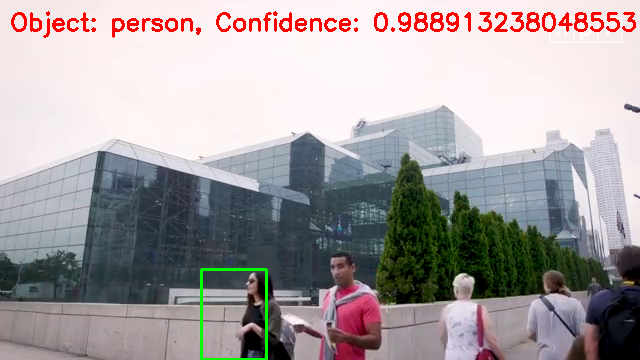


Frame Number:  170
Timestamp:  7465.78888888889


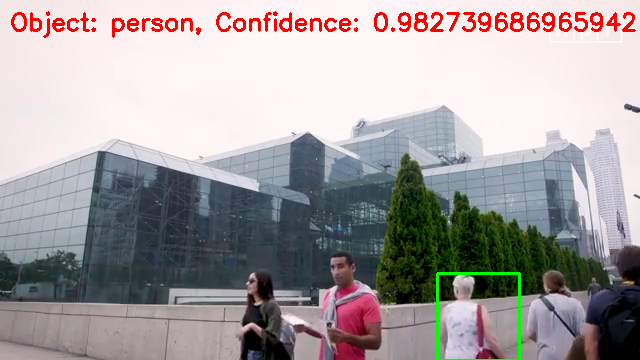


Frame Number:  570
Timestamp:  24149.1333333333


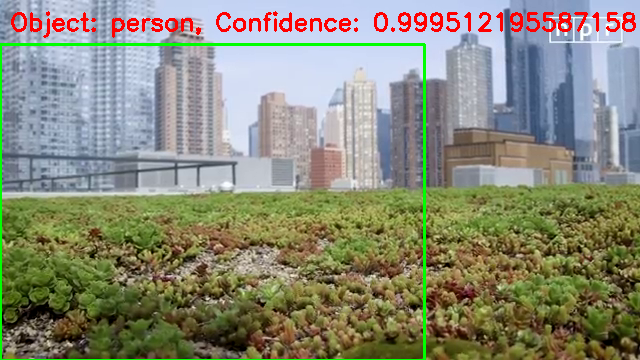


Frame Number:  580
Timestamp:  24566.2111111111


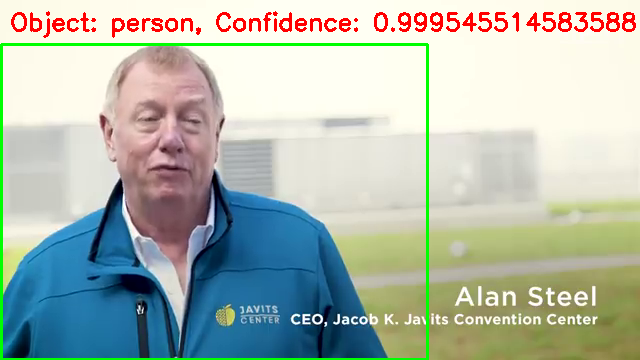


Frame Number:  590
Timestamp:  24983.3


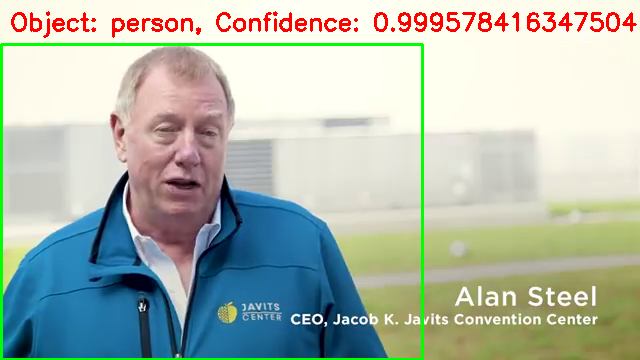


Frame Number:  600
Timestamp:  25400.3777777778


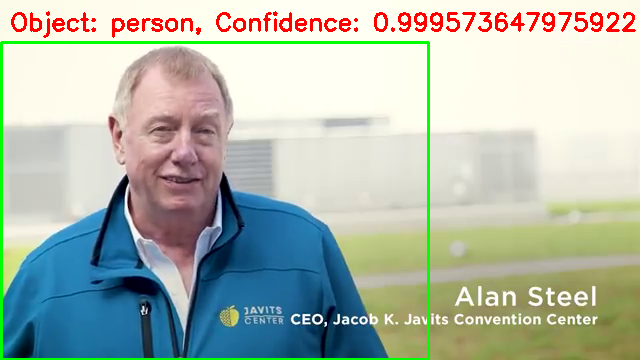


Frame Number:  610
Timestamp:  25817.4666666667


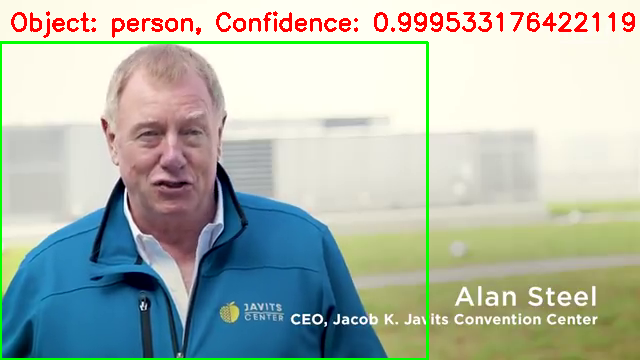

In [ ]:
# Define the SQL query
query = """
    SELECT * FROM detectedObjects
    WHERE detectedObjId = 1
    LIMIT 30;
"""

# Execute the query
cursor.execute(query)

# Fetch the results
results = cursor.fetchall()

for row in results[20:]:
  print("Frame Number: ", row[1])
  print("Timestamp: ", row[2])
  display_frame_with_bbox(video_paths[row[0]], row[1], row[4], row[5], row[6])
  print()

# Testing Object Data 2

As MS COCO is strongly biased toward person data, I am also including results from 2 of the rarer objects in the dataset. The following shows results of 'teddy bears', admittedly more of a teddy bird, but which should still be considered a true positive

Frame Number:  3800
Timestamp:  158867.044444444


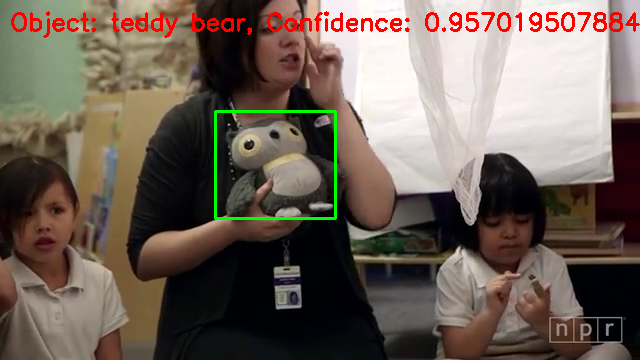


Frame Number:  3810
Timestamp:  159284.122222222


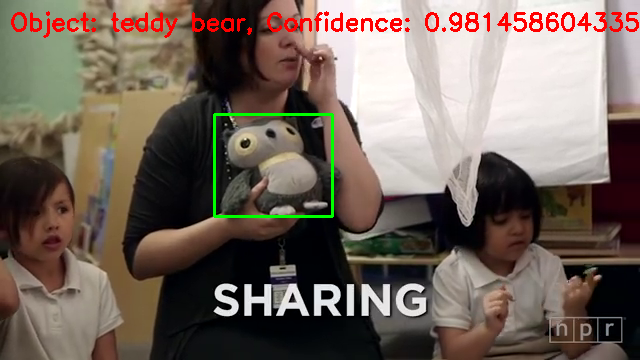

In [ ]:
# Define the SQL query
query = """
    SELECT * FROM detectedObjects
    WHERE detectedObjId = 88
    LIMIT 5;
"""

# Execute the query
cursor.execute(query)

# Fetch the results
results = cursor.fetchall()

for row in results:
  print("Frame Number: ", row[1])
  print("Timestamp: ", row[2])
  display_frame_with_bbox(video_paths[row[0]], row[1], row[4], row[5], row[6])
  print()

# Testing Object Data 3

One more example of a relatively rare element in the dataset, an actual bird (as opposed to a teddy bird). Note that in the false positive, there seems to be an early detection of the bird 10 frames before it appears, which is likely due to a bug in my code or in OpenCV. Generally I would assume it's me, but the appearance of these particular false positives are oddly inconsistent and tweaking the frame number function did not seem to fix the issue

Frame Number:  3700
Timestamp:  154696.211111111


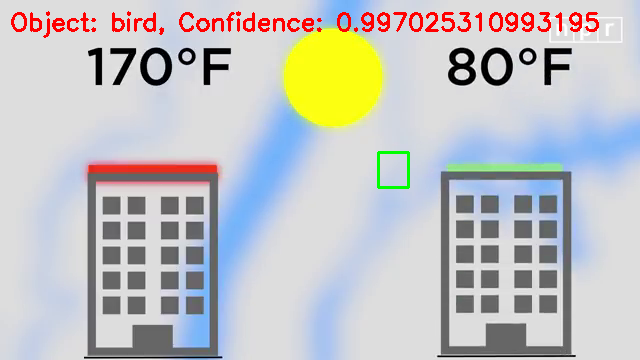


Frame Number:  3710
Timestamp:  155113.3


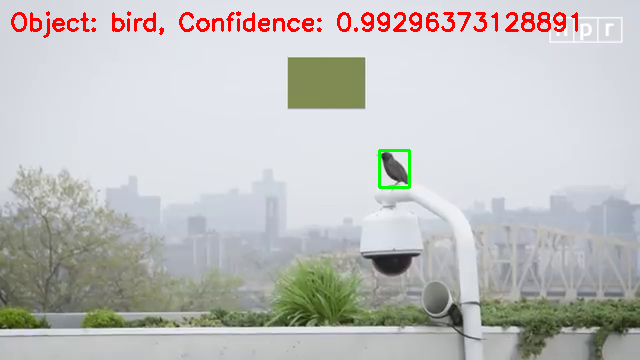


Frame Number:  3720
Timestamp:  155530.377777778


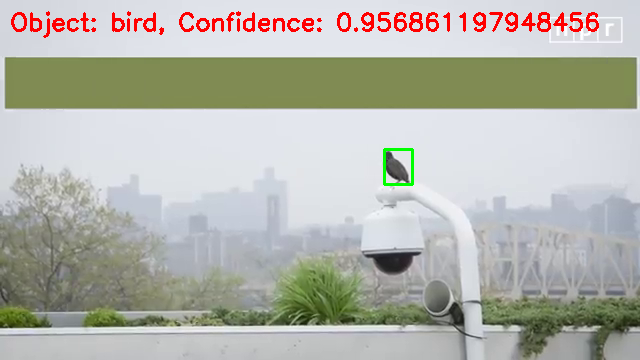


Frame Number:  3730
Timestamp:  155947.466666667


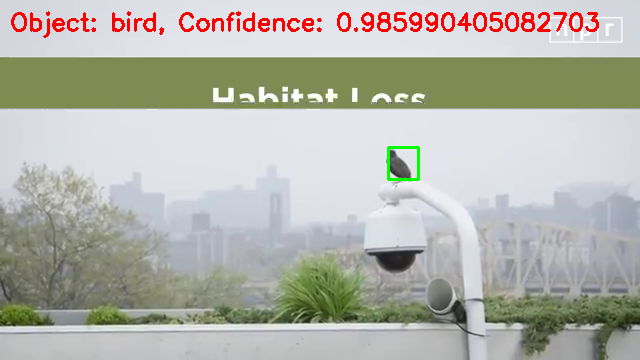


Frame Number:  3740
Timestamp:  156364.544444444


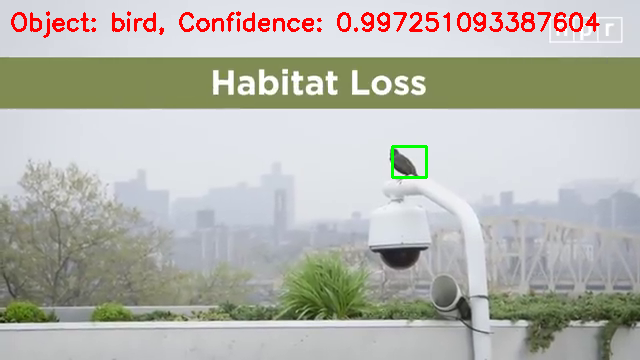

In [ ]:
# Define the SQL query
query = """
    SELECT * FROM detectedObjects
    WHERE detectedObjId = 16
    LIMIT 5;
"""

# Execute the query
cursor.execute(query)

# Fetch the results
results = cursor.fetchall()

for row in results:
  print("Frame Number: ", row[1])
  print("Timestamp: ", row[2])
  display_frame_with_bbox(video_paths[row[0]], row[1], row[4], row[5], row[6])
  print()

# Problem 2.3 Solution

Start by loading 2017 dataset. Attempted to use huggingface, but streaming option doesn't seem to have stable tensorflow support, so opted to save files on disk using wget to avoid overloading the RAM

In [ ]:
# Download COCO annotations file
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip -d /content/drive/MyDrive/ColabNotebooks/

# Download COCO images (train2017)
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip train2017.zip -d /content/drive/MyDrive/ColabNotebooks/

# Download COCO validation set images (val2017)
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip -d /content/drive/MyDrive/ColabNotebooks/

# Autoencoder Design

Small embedding vector of size 12x20x8, about 1/10 the size of the input image.

In [24]:
def build_autoencoder(input_shape=(90, 160, 3)):
    input_img = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = tf.keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

In [25]:
autoencoder=build_autoencoder()
autoencoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 90, 160, 3)]      0         
                                                                 
 conv2d_53 (Conv2D)          (None, 90, 160, 16)       448       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 45, 80, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 45, 80, 8)         1160      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 23, 40, 8)         0         
 ng2D)                                                           
                                                                 
 conv2d_55 (Conv2D)          (None, 23, 40, 8)         584 

In [68]:
# Define the paths for train2017 and val2017 datasets
train_data_dir = '/content/drive/MyDrive/ColabNotebooks/train2017/'
val_data_dir = '/content/drive/MyDrive/ColabNotebooks/val2017/'
target_size = (92, 156)

# Load the list of image files in the training directory
train_image_files = [f for f in os.listdir(train_data_dir) if os.path.isfile(os.path.join(train_data_dir, f))]

# Load the list of image files in the validation directory
val_image_files = [f for f in os.listdir(val_data_dir) if os.path.isfile(os.path.join(val_data_dir, f))]

# Create DataFrames with image file paths for training and validation
train_df = pd.DataFrame({'filename': train_image_files})
val_df = pd.DataFrame({'filename': val_image_files})

# Set the batch size for training
batch_size = 32
epochs = 5  # Adjust the number of training epochs as needed

# Create data generators for training and validation sets using flow_from_dataframe
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_dataset = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_data_dir,
    x_col='filename',
    y_col='filename',  # Use the same images for both input and target
    target_size = target_size,
    batch_size=batch_size,
    class_mode='input',  # Set class_mode to 'input' to use the same images for input and target
    shuffle=False,  # Set shuffle to False when dealing with individual image files
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_dataset = val_datagen.flow_from_dataframe(
    val_df,
    directory=val_data_dir,
    x_col='filename',
    y_col='filename',  # Use the same images for both input and target
    target_size = target_size,
    batch_size=batch_size,
    class_mode='input',  # Set class_mode to 'input' to use the same images for input and target
    shuffle=False,  # Set shuffle to False when dealing with individual image files
)

# Train the autoencoder on the COCO training set with validation
history = autoencoder.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
)

Found 118287 validated image filenames.
Found 5000 validated image filenames.
Epoch 1/5
29572/29572 [==============================] - 482s 16ms/step - loss: 0.5416 - val_loss: 0.5383
Epoch 2/5
29572/29572 [==============================] - 475s 16ms/step - loss: 0.5371 - val_loss: 0.5360
Epoch 3/5
29572/29572 [==============================] - 472s 16ms/step - loss: 0.5361 - val_loss: 0.5354
Epoch 4/5
29572/29572 [==============================] - 466s 16ms/step - loss: 0.5355 - val_loss: 0.5349
Epoch 5/5
29572/29572 [==============================] - 483s 16ms/step - loss: 0.5351 - val_loss: 0.5345


In [69]:
model_path = "/content/drive/MyDrive/ColabNotebooks/autoencoder_model.keras"
autoencoder.save(model_path)
print(f"Model saved to: {model_path}")

# Download the file
files.download(model_path)

Model saved to: /content/drive/MyDrive/ColabNotebooks/autoencoder_model.keras


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [92]:
# Function to capture a frame from the video
def capture_frame(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: Unable to open video.")
        return None

    # Set the frame number
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)

    # Read the frame
    ret, frame = cap.read()

    # Release the video capture object
    cap.release()

    if not ret:
        print(f"Error: Unable to read frame {frame_number} from video.")
        return None

    return frame

1/1 [==============================] - 0s 94ms/step


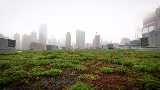

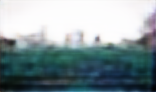

In [95]:
# Load a frame from the MP4 file
video_path = video_paths[0]
frame_number_to_capture = 50
input_size = (160, 90)

# Load the pre-trained autoencoder model
model_path = '/content/drive/MyDrive/ColabNotebooks/autoencoder_model.keras'
autoencoder = tf.keras.models.load_model(model_path)

# Capture a frame from the video
input_frame = capture_frame(video_path, frame_number_to_capture)

if input_frame is not None:
    # Preprocess the input frame
    input_frame_resized = cv2.resize(input_frame, input_size)
    input_frame_normalized = input_frame_resized / 255.0  # Normalize pixel values to [0, 1]
    input_frame_final = np.expand_dims(input_frame_normalized, axis=0)  # Add batch dimension

    # Use the autoencoder to reconstruct the frame
    reconstructed_frame = autoencoder.predict(input_frame_final)

    # Display the original frame
    cv2_imshow(input_frame_resized)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Display the reconstructed frame
    reconstructed_frame = (reconstructed_frame * 255).astype(np.uint8)
    reconstructed_frame_rgb = cv2.cvtColor(reconstructed_frame[0], cv2.COLOR_RGB2BGR)
    cv2_imshow(reconstructed_frame_rgb)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [ ]:
def crop_and_resize_images(dataType, dataDir, detected_classes, target_size=(640, 360)):
    # Specify the paths for the MS COCO dataset annotations and images
    annFile = f'{dataDir}/annotations/instances_{dataType}.json'
    imgDir = f'{dataDir}/{dataType}'

    # Initialize COCO API for annotations
    coco = COCO(annFile)

    # Create a directory to store modified images
    output_dir = f'/content/drive/MyDrive/ColabNotebooks/modified_mscoco/{dataType}'
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each detected class
    for class_id, class_name in detected_classes.items():
        # Get the category ID for the current class
        cat_ids = coco.getCatIds(catNms=[class_name])
        img_ids = coco.getImgIds(catIds=cat_ids)

        # Iterate over images containing the current class
        for img_id in img_ids:
            # Load image information
            img_info = coco.loadImgs(img_id)[0]

            # Load image using OpenCV
            img_path = os.path.join(imgDir, img_info['file_name'])
            image = cv2.imread(img_path)

            # Load annotations for the current image
            ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=cat_ids, iscrowd=None)
            annotations = coco.loadAnns(ann_ids)

            # Iterate over each annotation (bounding box) for the current class in the image
            for i, ann in enumerate(annotations):
                bbox = ann['bbox']
                bbox = [int(coord) for coord in bbox]

                # Crop the object image
                object_image = image[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]

                # Check if the cropped image is not empty
                if not object_image.size == 0:
                    # Resize the object image
                    resized_image = cv2.resize(object_image, target_size)

                    # Save the resized object image
                    output_path = os.path.join(output_dir, f'{class_name}_{img_info["file_name"]}_{i}.jpg')
                    cv2.imwrite(output_path, resized_image)

    print(f"Cropping and resizing of object images for {dataType} complete.")

In [ ]:
# Specify the paths for the MS COCO dataset annotations and images
dataDir = '/content/drive/MyDrive/ColabNotebooks'

# Crop and resize images for training dataset
crop_and_resize_images('train2017', dataDir, detected_classes)

# Crop and resize images for validation dataset
crop_and_resize_images('val2017', dataDir, detected_classes)

In [ ]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Specify the output directory where cropped and resized images are stored
output_dir = '/content/drive/MyDrive/ColabNotebooks/modified_mscoco'

# Display the first 10 cropped images with annotations
for class_id, class_name in detected_classes.items():
    # Get the list of filenames for the current class
    filenames = [filename for filename in os.listdir(output_dir) if class_name in filename]

    # Display up to the first image for the current class
    for i, filename in enumerate(filenames[:1]):
        img_path = os.path.join(output_dir, filename)

        # Read the image using OpenCV
        image = cv2.imread(img_path)

        # Read annotation information from the filename
        parts = filename.split('_')
        img_info = {'file_name': parts[1], 'id': parts[-1].split('.')[0]}

        # Load annotations for the current image
        ann_ids = coco.getAnnIds(imgIds=img_info['id'], catIds=[class_id], iscrowd=None)
        annotations = coco.loadAnns(ann_ids)

        # Display the image with annotations
        fig, ax = plt.subplots(1)
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Draw bounding boxes and annotations
        for ann in annotations:
            bbox = ann['bbox']
            bbox = [int(coord) for coord in bbox]

            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

        # Display the class name between images
        plt.title(f'Class: {class_name}', color='r', bbox={'color': 'white', 'alpha': 0.7, 'pad': 2})
        plt.axis('off')
        plt.show()
